# Prepare data in the format for modelling

In [1]:
import os
import numpy as np

import pandas as pd
import geopandas as gpd
from warnings import simplefilter
import sys

from docutils.writers.xetex import XeLaTeXTranslator
from sqlalchemy import column
from sqlalchemy.dialects.mssql.information_schema import columns

simplefilter(action='ignore', category=FutureWarning)
import geopy.distance

def add_sin_and_cos_features(df, column_to_transform):
    df['Sin_{}'.format(column_to_transform)] = np.sin(2 * np.pi * df[column_to_transform] / max(df[column_to_transform])) 
    df['Cos_{}'.format(column_to_transform)] = np.cos(2 * np.pi * df[column_to_transform] / max(df[column_to_transform]))
    return df

sys.path.append('../../3. Modelling')
from Functions import *

In [2]:
#buffer_sizes = [50, 100, 200, 400, 500, 600, 1000]
buffer_size_m = 400

### Prepare footfall data
<u> Including removing outliers:</u>  
The model should predict normal footfall. Therefore any days that have extremely high or low footfall should be taken out of the training data. We don't actually want the model to try to predict footfall on unusual days, because the things that make the day unusual (like errors in the camera counters, or the presence of special events) are not captured in the input data.

Outliers are detected using the Median Absolute Deviation method.

In [3]:
# Read in data
sensors = pd.read_csv('../../Cleaned_data/SensorData/allsensors.csv')
# Create month as number not string
sensors['datetime'] =pd.to_datetime(sensors['datetime'], format = '%Y-%m-%d %H:%M:%S')#dayfirst = False)
# Keep only data from 2011 onwards
sensors= sensors[sensors['year']>2010]
# # Create a categrorial variable defining the time of day
sensors['time_of_day'] = sensors.apply (lambda row: label_hours(row), axis=1)
sensors

/var/folders/bx/3j5z8qc50wl1tcff6xvbf2zh0000gs/T/ipykernel_45637/4006736533.py:2: DtypeWarning: Columns (9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  sensors = pd.read_csv('../../Cleaned_data/SensorData/allsensors.csv')


,sensor_id,Name,sensor_name,installation_date,status,note,Latitude,Longitude,location,Note,...,Status,datetime,year,month,mdate,day,time,hourly_counts,new_sensor,time_of_day
0,16,Australia on Collins,Col270_T,30/03/2009,R,Device moved to location ID 53 (22/09/2015),-37.815734,144.965210,"(-37.81573422, 144.96521044)",NaN,...,NaN,2011-01-01 00:00:00,2011,1,1,Saturday,0,744,False,nighttime
1,5,Princes Bridge,PriNW_T,26/03/2009,A,NaN,-37.818742,144.967877,"(-37.81874249, 144.96787656)",NaN,...,NaN,2011-01-01 00:00:00,2011,1,1,Saturday,0,5021,False,nighttime
2,10,Victoria Point,BouHbr_T,23/04/2009,A,NaN,-37.818765,144.947105,"(-37.81876473, 144.94710545)",NaN,...,NaN,2011-01-01 00:00:00,2011,1,1,Saturday,0,518,False,nighttime
3,15,State Library,QV_T,25/03/2009,R,NaN,-37.810644,144.964471,"(-37.81064378, 144.96447132)",NaN,...,NaN,2011-01-01 00:00:00,2011,1,1,Saturday,0,1581,False,nighttime
4,3,Melbourne Central,Swa295_T,25/03/2009,A,NaN,-37.811015,144.964295,"(-37.81101523, 144.96429485)",NaN,...,NaN,2011-01-01 00:00:00,2011,1,1,Saturday,0,2547,False,nighttime
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5480637,41,Flinders La-Swanston St (West),Swa31,29/06/2017,A,NaN,-37.816686,144.966897,"(-37.81668633, 144.96689733)",NaN,...,NaN,2024-09-17 03:00:00,2024,9,17,Tuesday,3,20,False,nighttime
5480638,4,Town Hall (West),Swa123_T,23/03/2009,A,NaN,-37.814880,144.966088,"(-37.81487988, 144.9660878)",NaN,...,NaN,2024-09-17 03:00:00,2024,9,17,Tuesday,3,14,False,nighttime
5480639,63,231 Bourke St,Bou231_T,07/01/2020,A,NaN,-37.813331,144.966756,"(-37.81333081, 144.96675572)",NaN,...,NaN,2024-09-17 03:00:00,2024,9,17,Tuesday,3,5,False,nighttime
5480640,42,Grattan St-Swanston St (West),UM1_T,15/04/2015,A,NaN,-37.800086,144.963864,"(-37.80008565, 144.96386412)",NaN,...,NaN,2024-09-17 03:00:00,2024,9,17,Tuesday,3,9,False,nighttime


### Remove outliers (sensor by sensor)

In [4]:
pcts = []
all_sensors = pd.DataFrame({})
for sensor_id in np.unique(sensors['sensor_id']):
    #print(sensor_id)
    this_sensor = sensors[sensors['sensor_id']==sensor_id]
    this_sensor, outliers, pct = remove_outliers(this_sensor)
    pcts.append(pct)
    all_sensors = pd.concat([all_sensors, this_sensor])

In [5]:
sensors= all_sensors

In [6]:
# Drop unneeded columns
sensors=sensors.drop(['Latitude', 'Longitude', 'location', 'mdate'], axis=1)
# Check the data
sensors.head()
len(sensors)

5436604

### Inspect outliers which have been removed

In [7]:
# # Look at outliers from particular day (which have reason to believe might have incldued outliers)
# t = [pd.to_datetime('2020-03-07 13:00:00')]
# this_day = outliers[outliers['datetime'].isin(t)]#[2255323]['datetime']
# # Look at biggest outliers
# test = outliers.nlargest(5, 'hourly_counts')
# # outliers[outliers['sensor_id']==57]
# # fig,ax=plt.subplots(figsize=(4,10))
# # outliers['sensor_id'].value_counts().sort_values().plot(kind = 'barh',ax=ax)
# test

### Inspecting sensor which has a lot of the outliers removed

In [8]:
# sensor_57 = sensors[sensors['sensor_id']==57]
# # Filter by a single date
# sensor_57_oneday = sensor_57[sensor_57['datetime'].dt.strftime('%Y-%m-%d') == "2019-11-15"]
# sensor_57_oneday.index=sensor_57_oneday['time']
# fig, ax = plt.subplots(figsize = (5,4), sharex = True)
# fig = sensor_57_oneday['hourly_counts'].plot(ax=ax, color='darkred', linewidth=2, legend =True)

## add date variables

In [9]:
sensors['day_of_month_num'] = sensors['datetime'].dt.day
sensors['weekday_num'] = sensors['datetime'].dt.weekday +1
sensors['month_num'] = sensors['datetime'].dt.month

### Join public holiday and weather data to sensor data (WHY DO NUMBER OF ROWS INCREASE SLIGHTLY?)

(_Code below added by NM because code above wasn't able to parse the dates correctly - probably a change in library versions_)

In [10]:
# Load and convert datetime columns explicitly
weather_data = pd.read_csv('../../Cleaned_data/WeatherData/weather_data_allyears.csv', parse_dates=['datetime'])
daily_rainfall = pd.read_csv('../../Cleaned_data/WeatherData/DailyRainfallData.csv', parse_dates=['datetime'])
public_holidays = pd.read_csv('../../Cleaned_data/HolidaysData/publicholidays.csv', parse_dates=['datetime'])
school_holidays = pd.read_csv('../../Cleaned_data/HolidaysData/schoolholidays.csv', parse_dates=['datetime'])

# Ensure datetime columns are in the correct format
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'], dayfirst=True)
daily_rainfall['datetime'] = pd.to_datetime(daily_rainfall['datetime'], dayfirst=True)
public_holidays['datetime'] = pd.to_datetime(public_holidays['datetime'], dayfirst=True)
school_holidays['datetime'] = pd.to_datetime(school_holidays['datetime'], dayfirst=True)

# Merge the dataframes
sensors_with_features = sensors.merge(weather_data, on='datetime', how='left')
sensors_with_features = sensors_with_features.merge(daily_rainfall, on='datetime', how='left')
sensors_with_features = sensors_with_features.merge(public_holidays, on='datetime', how='left')
sensors_with_features = sensors_with_features.merge(school_holidays, on='datetime', how='left')

# Also bring in the features near the sensors (no time column co can be merged directly)
sensors_with_features = sensors_with_features.merge(
    pd.read_csv('../../Cleaned_data/SpatialFeatures/sensors_betweenness.csv'), how='left', on='sensor_id')
sensors_with_features = sensors_with_features.merge(
    pd.read_csv('../../Cleaned_data/FeaturesNearSensors/num_features_near_sensors_{}.csv'.format(buffer_size_m), index_col=0), how='left', on='sensor_id')
sensors_with_features = sensors_with_features.merge(
    pd.read_csv('../../Cleaned_data/FeaturesNearSensors/feature_subtypes_near_sensors_{}.csv'.format(buffer_size_m), index_col=0), how='left', on='sensor_id')

In [11]:
print("Length is now: " , len(sensors_with_features))

Length is now:  5436621


### Add average number of floors of building in vicinity, for correct year 

In [12]:
sensors_with_features['avg_n_floors'] = sensors_with_features.apply (lambda row: select_n_floors(row), axis=1)
sensors_with_features = sensors_with_features[sensors_with_features.columns.drop(list(sensors_with_features.filter(regex='avg_n_floors_')))]

### Add buildings (correctly for the year the data relates to)

In [13]:
# FOR SENSORS WITH FEATURES
sensors_with_features['buildings'] = sensors_with_features.apply (lambda row: select_buildings(row), axis=1).copy()
sensors_with_features= sensors_with_features.drop(['buildings_2010', 'buildings_2011','buildings_2012', 'buildings_2013',
                                                  'buildings_2014','buildings_2015','buildings_2016','buildings_2017',
                                                  'buildings_2018', 'buildings_2019', 'buildings_2020'], axis =1)
# FOR SENSORS WITH SUBFEATURES
# Create a dataframe containing just the building subttypes for the year that this row refers to
temp = pd.DataFrame(None)
# For each year, get the data for just that year
for year in range(2011,2022+1):   
    # Get just footfall data for this year
    this_year = sensors_with_features[sensors_with_features['year'] == year]
    # If year is over 2020 then set the year to 2020 for the purposes of selecting the building data 
    if year > 2020:
        year = 2020
    # Get just the building columns for this year
    buildings_this_yr = this_year.filter(like='{}'.format(year))
    # Drop all the building subtype columns from the row (and the bikes) 
    this_year = this_year[this_year.columns.drop(list(this_year.filter(regex='bikes|buildings_')))]
     # Join the row without any buildings, back to this row 
    this_year = pd.concat([this_year, buildings_this_yr], axis=1)
    # Rename -- ??
    this_year.columns = this_year.columns.str.replace(r'_{}'.format(year), '')
    # Join to dataframe which will store data for all years eventually
    temp = pd.concat([temp, this_year])
sensors_with_features = temp.copy()

### Add dummy variables for calendar variables 
(Not doing this anymore as creating cos and sin variables)

### Create sin/cos variables to represent cyclical features

In [14]:
# Time refers to the hour of the day 0-23 (makes sense that this is cyclical - relationship between 23 and 0)
sensors_with_features = add_sin_and_cos_features(sensors_with_features, 'time')
# Month number from 1-12 (makes sense that this is cyclical - relationship between 12 and 1)
sensors_with_features = add_sin_and_cos_features(sensors_with_features, 'month_num')
# Weekday number from 1-7 (maybe doesnt make sense that this is cyclical - doesn't really follow a logical pattern?
sensors_with_features = add_sin_and_cos_features(sensors_with_features, 'weekday_num')

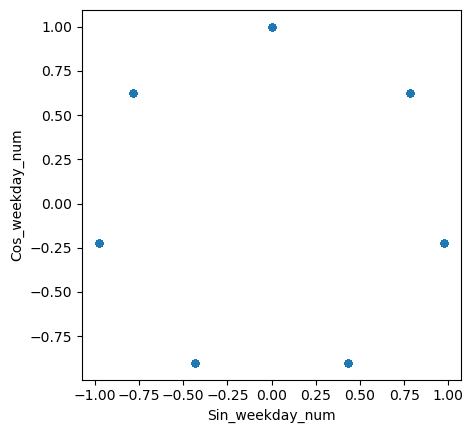

In [15]:
ax = sensors_with_features.plot.scatter('Sin_weekday_num', 'Cos_weekday_num').set_aspect('equal')

### Replace NaNs with 0s

In [16]:
sensors_with_features= sensors_with_features.fillna(0)

## Create aggregated data

In [17]:
# ### Filter to include just sensors which we know have quite complete data 
# data = sensors_with_features[sensors_with_features['sensor_id'].isin([2,6,9,10,14,18])]
# data.reset_index(inplace=True, drop = True)

# # Get just this hourly counts
# hourly_counts = data[['datetime', "hourly_counts"]]
# # Get the sum of all values for one hour
# summed_hourly_counts = hourly_counts.groupby("datetime").sum()
# # reset index (for joining)
# summed_hourly_counts.reset_index(inplace = True, drop = True)

# # Get just the features
# features = data[['datetime','Temp', 'Humidity', 'Pressure', 'Rain', 'WindSpeed',
#        'public_holiday','school_holiday','Sin_time', 'Cos_time', 'Sin_month_num', 'Cos_month_num', 'Sin_weekday_num', 'Cos_weekday_num']]
# # Keep only one version of each row (should all be the same)
# features = features.drop_duplicates(keep='last')
# # reset index (for joining)
# features.reset_index(inplace = True, drop = True)

# # Join features to aggregated count values
# aggregated = pd.concat([summed_hourly_counts, features], axis=1, join='inner')

In [18]:
# for column in sensors_with_features.columns:
#     print(column, np.nanmax(sensors_with_features[column]))

### Remove time variables no longer required

In [19]:
# sensors_with_features = sensors_with_features.drop([ 'Sin_month_num', 'Cos_month_num', 'Sin_weekday_num',
#        'Cos_weekday_num',],axis=1)

### Add distance from centre as a variable

In [20]:
### Read in Melbourne sensor location spatial data
melbourne_sensors = pd.read_csv("../../Cleaned_data/SensorData/sensor_locations.csv")
assert melbourne_sensors['sensor_id'].is_unique
#melbourne_sensors = melbourne_sensors.drop_duplicates('sensor_id', keep='first')

# Coordinates of 'centre' of CBD (done on google maps)
coords_1 = (-37.812187461761596, 144.962265054567)
distances =[]
for row_number in range(0,len(melbourne_sensors)):
    coords_2 = (melbourne_sensors['Latitude'][row_number], melbourne_sensors['Longitude'][row_number])
    distances.append(geopy.distance.geodesic(coords_1, coords_2).km)
    
melbourne_sensors['distance_from_centre']=distances

In [21]:
sensors_with_features= pd.merge(sensors_with_features, melbourne_sensors[['sensor_id','distance_from_centre']], on=['sensor_id'], how='left')

### Add census variables

The census variables are stored in `census_data.gpkg`. Its a spatial file that has, for each of the three census years (2011, 2016, 2021), the census data for each of the census variables. The boundaries are different for each year because they changed slightly. Therefore this section will go through all sensor counts, find the closest year, then find the SA1 region that the sensor is within.

In [22]:
census_gdf = gpd.read_file(os.path.join("..", "..", "Cleaned_data", "CensusData", "census_data.gpkg"), layer='census_data')
census_gdf.sample(10)

,mean_age,mean_income,mean_school_year,year,geometry
2177,35.578348,1428.109827,11.533981,2016,"MULTIPOLYGON (((144.98967 -37.85288, 144.98988..."
609,40.400966,1011.783762,11.792490,2011,"MULTIPOLYGON (((144.95754 -37.78115, 144.95746..."
2824,38.160211,1270.779588,11.454183,2021,"POLYGON ((144.91704 -37.76168, 144.91691 -37.7..."
1726,35.867692,1070.688988,11.537255,2016,"MULTIPOLYGON (((144.92693 -37.79332, 144.92711..."
1222,35.243021,766.526667,11.382231,2016,"MULTIPOLYGON (((144.97114 -37.75625, 144.97041..."
2321,40.660448,1110.285849,11.452381,2016,"MULTIPOLYGON (((144.97886 -37.77546, 144.97873..."
3112,35.918033,1069.500000,11.953488,2021,"POLYGON ((144.95975 -37.81137, 144.95986 -37.8..."
3810,32.850427,1802.824795,11.812500,2021,"POLYGON ((145.00719 -37.82572, 145.00719 -37.8..."
54,35.288177,955.802532,11.548485,2011,"MULTIPOLYGON (((144.97139 -37.77339, 144.97127..."
6,35.000000,834.843612,11.441734,2011,"MULTIPOLYGON (((144.96302 -37.76714, 144.96350..."


Re-read the Melbourne sensors as a geodataframe this time

In [23]:
### Read in Melbourne sensor location spatial data
sensor_locs_df = pd.read_csv(os.path.join("..", "..", "Cleaned_data", "SensorData", "sensor_locations.csv"))
sensor_locs_gdf = (gpd.GeoDataFrame(sensor_locs_df, geometry=gpd.points_from_xy(sensor_locs_df['Longitude'], sensor_locs_df['Latitude'])).
               set_crs(epsg=4326, inplace=True))

First find out which SA (area) each sensor fits within (remembering that the boundaries may change between the census years)

In [24]:
# Perform a spatial join to find the index of the area each point is within, for each year
for year in [2011, 2016, 2021]:
    sensor_locs_gdf[f'sa1_{year}_index'] = gpd.sjoin(sensor_locs_gdf, census_gdf.loc[census_gdf.year==year,:], 
                                                  how='left', op='within').index_right
    # Check the join worked for all sensors
    assert sensor_locs_gdf[f'sa1_{year}_index'].notna().all()
sensor_locs_gdf

,sensor_id,Name,sensor_name,installation_date,status,note,Latitude,Longitude,location,Note,Location_Type,Status,geometry,sa1_2011_index,sa1_2016_index,sa1_2021_index
0,16,Australia on Collins,Col270_T,30/03/2009,R,Device moved to location ID 53 (22/09/2015),-37.815734,144.965210,"(-37.81573422, 144.96521044)",NaN,NaN,NaN,POINT (144.96521 -37.81573),540,1745,3089
1,50,Faraday St-Lygon St (West),Lyg309_T,30/11/2017,A,NaN,-37.798082,144.967210,"(-37.79808191, 144.96721014)",NaN,NaN,NaN,POINT (144.96721 -37.79808),450,1652,2912
2,73,Bourke St - Spencer St (South),Bou655_T,02/10/2020,I,NaN,-37.816957,144.954154,"(-37.81695684, 144.95415373)",NaN,NaN,NaN,POINT (144.95415 -37.81696),542,1747,3137
3,66,State Library - New,QVN_T,06/04/2020,A,NaN,-37.810578,144.964443,"(-37.81057845, 144.96444294)",NaN,NaN,NaN,POINT (144.96444 -37.81058),557,1772,3106
4,59,Building 80 RMIT,RMIT_T,13/02/2019,A,NaN,-37.808256,144.963049,"(-37.80825648, 144.96304859)",NaN,NaN,NaN,POINT (144.96305 -37.80826),559,1770,3123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,140,COM Pole 2837 - Boyd Park,Boyd2837_T,2023-11-02,NaN,NaN,-37.825910,144.961860,"(-37.82590962, 144.96185972)",NaN,Outdoor,A,POINT (144.96186 -37.82591),657,1872,3220
138,150,narrm ngarrgu Library - Level 1 Main Stairs B,narrLibL1MB_T,2023-10-23,NaN,NaN,-37.807912,144.958201,"(-37.80791198, 144.95820087)",NaN,Indoor,A,POINT (144.95820 -37.80791),558,1771,3117
139,152,narrm ngarrgu Library - Level 2 - Study Area L...,narrLibL2S1_T,2023-10-23,NaN,NaN,-37.807767,144.958440,"(-37.80776728, 144.95843977)",NaN,Indoor,A,POINT (144.95844 -37.80777),558,1771,3117
140,154,narrm ngarrgu Library - Level 3 Children's Lib...,narrLibL3C1_T,2023-10-23,NaN,NaN,-37.807784,144.958628,"(-37.80778437, 144.95862772)",NaN,Indoor,A,POINT (144.95863 -37.80778),558,1771,3117


Now link those areas to the census variables so that we get a new column for each census variable / year combination

In [25]:
census_data_columns = ["mean_age", "mean_income", "mean_school_year"]
for year in [2011, 2016, 2021]:
    for column in census_data_columns:
        sensor_locs_gdf[f'{column}_{year}'] = sensor_locs_gdf.apply(
            lambda row: census_gdf.at[row[f'sa1_{year}_index'], column], axis=1)

In [26]:
sensor_locs_gdf

,sensor_id,Name,sensor_name,installation_date,status,note,Latitude,Longitude,location,Note,...,sa1_2021_index,mean_age_2011,mean_income_2011,mean_school_year_2011,mean_age_2016,mean_income_2016,mean_school_year_2016,mean_age_2021,mean_income_2021,mean_school_year_2021
0,16,Australia on Collins,Col270_T,30/03/2009,R,Device moved to location ID 53 (22/09/2015),-37.815734,144.965210,"(-37.81573422, 144.96521044)",NaN,...,3089,33.731518,882.593750,11.797980,32.413851,794.914802,11.798165,34.525203,1077.156034,11.817623
1,50,Faraday St-Lygon St (West),Lyg309_T,30/11/2017,A,NaN,-37.798082,144.967210,"(-37.79808191, 144.96721014)",NaN,...,2912,30.068293,692.229025,11.859599,28.752315,733.588167,11.885294,33.024768,1227.158358,11.813880
2,73,Bourke St - Spencer St (South),Bou655_T,02/10/2020,I,NaN,-37.816957,144.954154,"(-37.81695684, 144.95415373)",NaN,...,3137,28.956938,852.947253,11.771574,27.162859,614.008382,11.861290,29.182149,1056.118007,11.798493
3,66,State Library - New,QVN_T,06/04/2020,A,NaN,-37.810578,144.964443,"(-37.81057845, 144.96444294)",NaN,...,3106,27.310235,717.478734,11.820093,28.621514,749.509217,11.888298,36.858333,1418.716561,11.522293
4,59,Building 80 RMIT,RMIT_T,13/02/2019,A,NaN,-37.808256,144.963049,"(-37.80825648, 144.96304859)",NaN,...,3123,26.686610,670.436950,11.821752,23.753045,366.107259,11.866505,29.225670,852.865493,11.826156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,140,COM Pole 2837 - Boyd Park,Boyd2837_T,2023-11-02,NaN,NaN,-37.825910,144.961860,"(-37.82590962, 144.96185972)",NaN,...,3220,36.075049,925.971287,11.487903,28.506269,805.789363,11.798692,29.841499,939.250000,11.746130
138,150,narrm ngarrgu Library - Level 1 Main Stairs B,narrLibL1MB_T,2023-10-23,NaN,NaN,-37.807912,144.958201,"(-37.80791198, 144.95820087)",NaN,...,3117,26.587558,481.357677,11.828094,25.245633,450.037277,11.825137,35.485915,621.503460,11.480769
139,152,narrm ngarrgu Library - Level 2 - Study Area L...,narrLibL2S1_T,2023-10-23,NaN,NaN,-37.807767,144.958440,"(-37.80776728, 144.95843977)",NaN,...,3117,26.587558,481.357677,11.828094,25.245633,450.037277,11.825137,35.485915,621.503460,11.480769
140,154,narrm ngarrgu Library - Level 3 Children's Lib...,narrLibL3C1_T,2023-10-23,NaN,NaN,-37.807784,144.958628,"(-37.80778437, 144.95862772)",NaN,...,3117,26.587558,481.357677,11.828094,25.245633,450.037277,11.825137,35.485915,621.503460,11.480769


Finally join this to the sensors_with_features, assigning the appropriate columns depending on the time of the hourly count.

This takes ages as it does a row-by-row apply. I'm sure there's a better way to do this using temporary columns and joins, but I haven't really thought about it. Would be a good thing to do in the future. At least I can fairly easily cache the result.

In [27]:
# Define the census dates
census_dates = pd.to_datetime(["2011-08-09", "2016-08-09", "2021-08-10"])
census_years = [2011, 2016, 2021]

def get_census_variables(row, census_cols):
    """Assign the census variables to the row based on the time of the pedestrian count (find the closest census year).
    Return a tuple with the chosen value for each of the input columns
    
    row: pd.Series: a row of the sensors_with_features dataframe
    census_cols: list: the list of census columns
    """
    # Find the closest census year
    closest_date = census_dates[np.argmin(abs(census_dates - row.datetime))]
    year = census_years[census_dates.get_loc(closest_date)]
    
    # Append the year to the column names
    cols = [f'{col}_{year}' for col in census_cols]
    
    # Find the right variables for this sensor
    census_variables = sensor_locs_gdf.loc[sensor_locs_gdf.sensor_id == row.sensor_id, cols]
    assert len(census_variables) == 1 , "Should only get 1 row"
    assert census_variables.notna().all().all(), "There are None or NaN values in the result."
    
    
    # Return the values as a tuple
    return tuple(census_variables.iloc[0])

def is_valid_cache(cached_data, _sensors_with_features, census_columns):
    """Working out the right census data for every sensor/hour takes ages, so I cache
    the results and this function checks to see if the cache exists and is valid"""
    # Check if the cached data is a pandas Series
    if not isinstance(cached_data, pd.Series):
        print("Cached data is not a pandas Series.")
        return False
    # Check if the length matches
    if len(cached_data) != len(_sensors_with_features):
        print("Cached data length does not match reference DataFrame.")
        return False
    # Check the size of the tuples matches the length of the census columns
    lengths = [len(t) for t in cached_data.values.tolist()]
    if not all(length == len(census_data_columns) for length in lengths):
        print(f"Cached data tuples are not all the same length (should be {len(census_data_columns)}).")
        return False
    # Check if the indices match
    if not cached_data.index.equals(_sensors_with_features.index):
        print("Cached data indices do not match reference DataFrame indices.")
        return False
    return True

# First, lets see if there is a cached result from a previous run (it sould be a long list of tuples,
# with one value for each of the census columns)
cache_file = 'census_variable_tuples.pkl' # Define the cache file path
compute = True  # Whether to recompute (only set to true if there is a cache file and it is valid)
if os.path.exists(cache_file):
    print("Cache file found. Attempting to load cached data...")
    # Load the cached data
    cached_tuples = pd.read_pickle(cache_file)
    # Validate the cached data
    if is_valid_cache(cached_tuples, sensors_with_features, census_data_columns):
        print("Cached data is valid. Using cached census_variable_tuples.")
        census_variable_tuples = cached_tuples
        compute = False
else:
    print("Cache file not found. Computing census_variable_tuples.")

if compute:
    # Joining takes a while. Try to use swifter to speed up the process, but if it is not available just do it the normal way
    try:
        import swifter
        print("swifter library is available. Using it to try to the join on multiple threads")
        census_variable_tuples = sensors_with_features.swifter.apply(get_census_variables, args=(census_data_columns,), axis=1)
    except ImportError:
        print("swifter library is not available. If you install it (conda install swifter) the join may be much faster")
        census_variable_tuples = sensors_with_features.apply(get_census_variables, args=(census_data_columns,), axis=1)
    # Save the computed data to cache
    census_variable_tuples.to_pickle(cache_file)

# Now assign those variables to columns in the dataframe
for i in range(len(census_data_columns)):
    sensors_with_features[census_data_columns[i]] = [x[i] for x in census_variable_tuples]
    

Cache file found. Attempting to load cached data...
Cached data is valid. Using cached census_variable_tuples.


In [28]:
sensors_with_features.loc[:,['datetime', 'sensor_id', 'mean_age', 'mean_income', 'mean_school_year']]

,datetime,sensor_id,mean_age,mean_income,mean_school_year
0,2011-12-20 00:00:00,1,28.835131,697.795287,11.836773
1,2011-12-20 01:00:00,1,28.835131,697.795287,11.836773
2,2011-12-20 02:00:00,1,28.835131,697.795287,11.836773
3,2011-12-20 03:00:00,1,28.835131,697.795287,11.836773
4,2011-12-20 04:00:00,1,28.835131,697.795287,11.836773
...,...,...,...,...,...
4374471,2022-12-31 19:00:00,118,37.993492,1299.568330,11.803125
4374472,2022-12-31 20:00:00,118,37.993492,1299.568330,11.803125
4374473,2022-12-31 21:00:00,118,37.993492,1299.568330,11.803125
4374474,2022-12-31 22:00:00,118,37.993492,1299.568330,11.803125


### Save as csv

_Note that we reduce the size of floats to a more sensible number of decimal places (significantly reduces file size)_

In [33]:
# Define a custom float formatting function so that we can have N decimal places
# without trailing zeros (weirdly difficult!)
def format_float(x):
    if x == 0:
        return '0'  # Ensure zero is represented as '0' and not an empty string
    else:  # Format the number to 4 dp, but then remove trailing zeros and decimal point
        s = ('%.4f' % x).rstrip('0').rstrip('.')
        return s

# Actually significant figures is better
def format_sigfig(x):
    if x == 0:
        return '0'  # Zero is a special case
    else:
        return '{0:.4g}'.format(x)

dir="../../Cleaned_data/FormattedDataForModelling/"
os.makedirs(dir, exist_ok=True)
sensors_with_features.to_csv(dir+"formatted_data_for_modelling_allsensors_{}_outlierremovaleachsensor.csv".format(buffer_size_m),
                            #float_format=format_float,
                            float_format=format_sigfig,
                            index = False)